In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from utils import settings
from utils.preprocessing import data_processing_end, get_file_names, data_processing_us_bls

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

# Data Preprocessing

### Data Sources

CPI, Unemployment: bureau of labor statistics


OECD GDP growth rates: https://data.oecd.org/gdp/quarterly-gdp.htm#indicator-chart  DP_LIVE_02062020181713872

USA GDP growth rates: https://www.multpl.com/us-gdp-growth-rate/table/by-quarter

Recession: http://www.nber.org/cycles/cyclesmain.html

USA public debt: https://fred.stlouisfed.org/series/GFDEBTN/, https://fred.stlouisfed.org/series/GFDEGDQ188S

EURUSD, USDCNY, VIX, GSPC: yahoo finance

trade balance (all and petroleum products): census.gov

WTI oil prices: https://fred.stlouisfed.org/series/WTISPLC

Fed funds rates month avg: https://fred.stlouisfed.org/series/fedfunds

Fed funds rates daily spot: https://fred.stlouisfed.org/series/DFF


In [3]:
settings.init()
settings.add('LAST_AVLBLE_DATE', dt.datetime.today() - pd.tseries.offsets.DateOffset(months=1))
print("No data considered after %s: not enough available data\n" % settings.get('LAST_AVLBLE_DATE').strftime('%Y/%m/%d'))

settings.add('PATH_TO_DATA', "Data/other/")

No data considered after 2020/05/11: not enough available data



### 1. CPI and unemployment: data from US Bureau of Labor Statistics, MONTHLY

In [4]:
data_bls = data_processing_us_bls(get_file_names(path = "Data/US_BLS/"), "Data/US_BLS/")
# data_bls.tail()
data_bls.head()

,cpi_all_seas,cpi_all_unadj,cpi_energy_seas,cpi_energy_unadj,cpi_less_energy_seas,cpi_less_energy_unadj,empl_pop_ratio_seas,empl_pop_ratio_unadj,unempl_level_seas,unempl_level_unadj,unempl_rate_seas,unempl_rate_unadj
Date,,,,,,,,,,,,
1913-01-31,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913-02-28,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913-03-31,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913-04-30,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913-05-31,NaN,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. GDP growth rates: USA, EU, Eurozone, OECD, G7, G20, QUARTERLY

In [5]:
data_oecd = pd.read_csv(settings.get('PATH_TO_DATA') + "economics_oecd_growth_rate.csv")
data_oecd['Date'] = pd.to_datetime(data_oecd['TIME'].str.replace(' ', '')) + pd.offsets.QuarterEnd(0)
data_oecd['Value'] = pd.to_numeric(data_oecd['Value'])
data_oecd = pd.pivot(data_oecd, values='Value', index='Date', columns='LOCATION')
data_oecd = data_oecd.add_suffix('_GDP_gth_rate')

# Convert to monthly data by taking the monthly growth rate y = (1+x)**(1/3) - 1
data_oecd = data_oecd.resample('M').asfreq()
data_oecd = data_oecd.applymap(lambda x: (1+x/100)**(1/3) - 1).fillna(method='ffill')
# data_oecd.describe()
data_oecd.tail()

LOCATION,EA19_GDP_gth_rate,EU27_2020_GDP_gth_rate,G-20_GDP_gth_rate,G-7_GDP_gth_rate,OECD_GDP_gth_rate,USA_GDP_gth_rate
Date,,,,,,
2019-11-30,0.001025,0.001215,0.002472,0.001221,0.001352,0.001736
2019-12-31,0.000362,0.000562,0.001996,0.000020,0.000532,0.001755
2020-01-31,0.000362,0.000562,0.001996,0.000020,0.000532,0.001755
2020-02-29,0.000362,0.000562,0.001996,0.000020,0.000532,0.001755
2020-03-31,-0.012662,-0.011226,0.001996,-0.006775,-0.006036,-0.004306


In [6]:
# data = pd.read_csv(settings.get('PATH_TO_DATA') + "economics_gdp_growth.csv")
# data_gdp = data_processing_end(data, date_format="%m/%d/%Y", visualize=True)
# # data_gdp.describe()
# data_gdp.head()

### 3. Recession periods data (binary): from FRED, MONTHLY

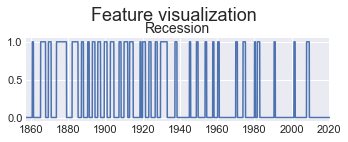

,Recession
Date,
1857-06-30,False
1857-07-31,False
1857-08-31,False
1857-09-30,False
1857-10-31,False


In [7]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "economics_recession.csv")
data = data[1:34]
data['StartDate'] = pd.to_datetime(data['Peak month']) - pd.offsets.MonthEnd(0)
data['EndDate'] = pd.to_datetime(data['Trough month']) + pd.offsets.MonthEnd(0)

# create date range
dates = pd.DataFrame(pd.date_range(
    start=data.min().StartDate,
    end=settings.get('LAST_AVLBLE_DATE'),
    freq='M'), columns=['Date'])

# merge for start date, then end date
dates = pd.merge(left=dates,
              right=data['StartDate'],
              left_on='Date',
              right_on='StartDate',
              how='outer'
             ).fillna(method='ffill')
data_recession = pd.merge(left=dates,
              right=data['EndDate'],
              left_on='Date',
              right_on='EndDate',
              how='outer'
             ).fillna(method='ffill')

data_recession['Recession'] = data_recession['StartDate'] > data_recession['EndDate']
data_recession.drop(columns=['StartDate', 'EndDate'], inplace=True)
data_recession = data_processing_end(data_recession, visualize=True)
# data_recession.describe()
data_recession.head()


### 4. US Public debt (nominal and share of GDP) QUARTERLY

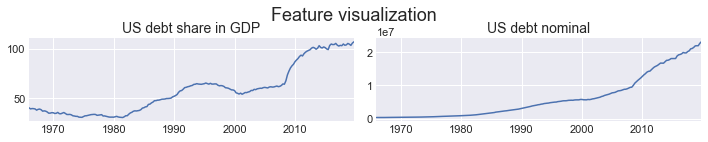

,US_debt_share_in_GDP,US_debt_nominal
Date,,
1965-12-31,40.339990,320999.000000
1966-01-31,39.982537,319365.000000
1966-02-28,39.625083,317731.000000
1966-03-31,39.267630,316097.000000
1966-04-30,39.385390,318980.666667


In [8]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "economics_us_debt.csv")
data.rename(columns={
    'DATE':'Date',
    'GFDEGDQ188S': 'US_debt_share_in_GDP',
    'GFDEBTN': 'US_debt_nominal'}, inplace=True)

# Convert to monthly data with linear interpolation
data_debt = data_processing_end(data, date_format="%m/%d/%Y", month_offset=1, visualize=True)
data_debt = data_debt.resample('M').asfreq()
data_debt.interpolate(method ='linear', limit_direction ='forward', inplace=True)

# data_debt.describe()
data_debt.head()

### 5. Forex: USD versus EUR and CNY MONTHLY

In [9]:
# data_eur = pd.read_csv(settings.get('PATH_TO_DATA') + "EURUSD=X.csv")
# data_eur.rename(columns={'Close':'EURUSD'}, inplace=True)
# data_cny = pd.read_csv(path_to_data + "USDCNY=X.csv")
# data_cny.rename(columns={'Close':'USDCNY'}, inplace=True)
# data = pd.merge(data_cny[['Date', 'USDCNY']],
#                 data_eur[['Date', 'EURUSD']],
#                 left_on='Date',
#                 right_on='Date',
#                 how='outer'
#                )
# data_fx = data_processing_end(data, month_offset=1)
# # data_fx.describe()
# data_fx.tail()

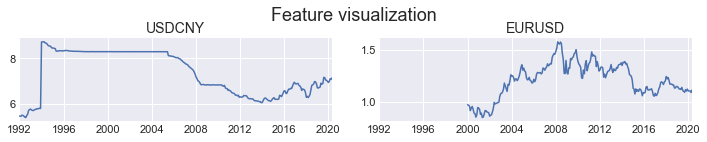

,USDCNY,EURUSD
Date,,
1991-12-31,5.4686,NaN
1992-01-31,5.4693,NaN
1992-02-29,5.4675,NaN
1992-03-31,5.5101,NaN
1992-04-30,5.4911,NaN


In [10]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "currencies.csv")
data.rename(columns={'Year': 'Date'}, inplace=True)
data_fx = data_processing_end(data, date_format="%m/%d/%Y", columns=['USDCNY', 'EURUSD'], month_offset=1, visualize=True)
data_fx.head()


### 6. Financial data: S&P500 levels and volatility MONTHLY

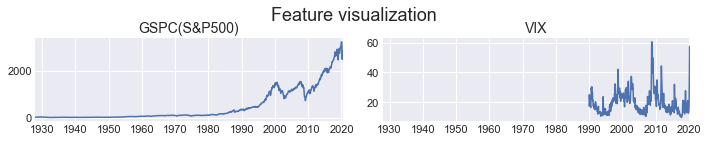

,GSPC(S&P500),VIX
Date,,
1927-11-30,17.660000,NaN
1927-12-31,17.760000,NaN
1928-01-31,17.530001,NaN
1928-02-29,17.299999,NaN
1928-03-31,18.910000,NaN
...,...,...
2019-12-31,3244.669922,13.460000
2020-01-31,3235.659912,18.639999
2020-02-29,2974.280029,38.540001


In [25]:
data_vix = pd.read_csv(settings.get('PATH_TO_DATA') + "finance_vix_volatility.csv")
data_vix.rename(columns={'Open':'VIX'}, inplace=True)
data_sp = pd.read_csv(settings.get('PATH_TO_DATA') + "finance_gspc.csv")
data_sp.rename(columns={'Open':'GSPC(S&P500)'}, inplace=True)
data = pd.merge(data_sp[['Date', 'GSPC(S&P500)']],
                data_vix[['Date', 'VIX']],
                left_on='Date',
                right_on='Date',
                how='outer'
               )
data_fin = data_processing_end(data, month_offset=1, visualize=True)
# data_fin.describe()
data_fin

### 7. Political data: political orientation of Potus, House of Rep and Fed Chairman MONTHLY

R or 0 stands for Republican, D or 1 stands for Democrat

In [12]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "political_orientation.csv")
data['Date'] = pd.to_datetime(data['year'].apply(str) + "-" + data['period'], format="%Y-M%m")
data.drop(columns=['year', 'period'], inplace=True)
for col in data.columns:
    data[col] = data[col].astype('string')
data_pol = data_processing_end(data, month_offset=1, columns=[], visualize=True)
data_pol.head()

,potus,houseOfRep,fedChair
Date,,,
1947-12-31,D,R,R
1948-01-31,D,R,R
1948-02-29,D,R,R
1948-03-31,D,R,R
1948-04-30,D,R,D


### 8. Trade: US trade balance for goods and services MONTHLY

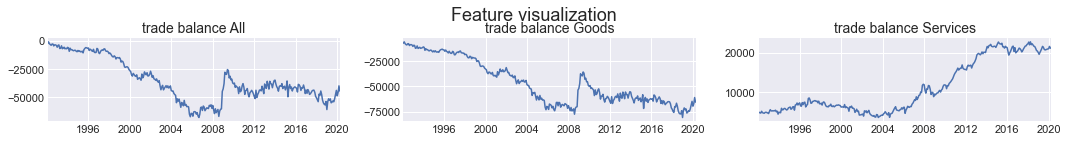

,trade_balance_All,trade_balance_Goods,trade_balance_Services
Date,,,
1992-01-31,-2026,-6952,4926
1992-02-29,-831,-5593,4762
1992-03-31,-2641,-7355,4714
1992-04-30,-3109,-8284,5175
1992-05-31,-3919,-8720,4801


In [13]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "trad-time-series-0320.csv")
data.drop(columns=data.columns[4:], inplace=True)
data.rename(columns={
    'Last updated May 5, 2020': 'Date',
    'Unnamed: 1': 'trade_balance_All',
    'Unnamed: 2': 'trade_balance_Goods',
    'Unnamed: 3': 'trade_balance_Services'
    }, inplace=True)
data = data[68:]
data = data[data['trade_balance_All'].notna()]
data['Date'] = pd.to_datetime(data['Date'], format="%Y%b") + pd.offsets.MonthEnd(0)
data_trade = data_processing_end(data, visualize=True)
# data_trade.describe()
data_trade.head()

### 9. WTI Oil prices, US petroleum products trade balance MONTHLY

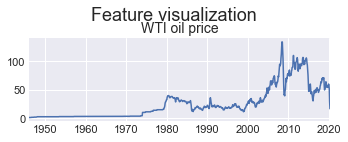

,WTI_oil_price
Date,
1945-12-31,1.17
1946-01-31,1.17
1946-02-28,1.17
1946-03-31,1.27
1946-04-30,1.27


In [14]:
data = pd.read_csv(settings.get('PATH_TO_DATA') + "WTISPLC.csv")
data.rename(columns={
    'DATE':'Date',
    'WTISPLC':'WTI oil price'
    }, inplace=True)
data_oil = data_processing_end(data, month_offset=1, visualize=True)
# data_oil.describe()
data_oil.head()

### 10. Fed funds affectice rates: monthly average and end-of-month spot value MONTHLY

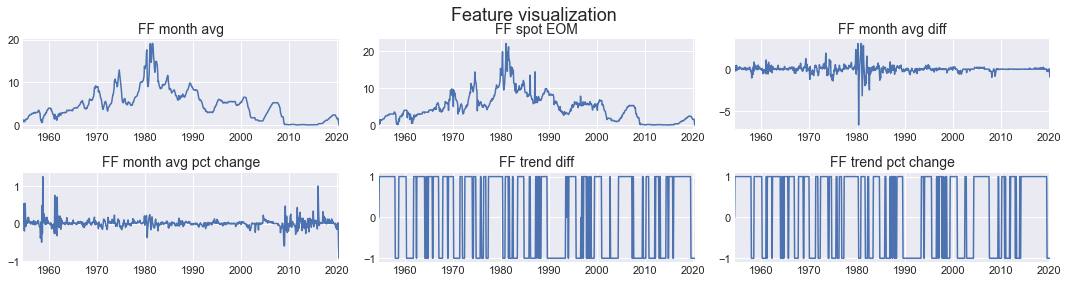

,FF_month_avg,FF_spot_EOM,FF_month_avg_diff,FF_month_avg_pct_change,FF_trend_diff,FF_trend_pct_change
Date,,,,,,
1954-07-31,0.80,1.13,0.00,0.000000,0,0
1954-08-31,1.22,0.25,0.42,0.525000,1,1
1954-09-30,1.06,1.44,-0.16,-0.131148,1,1
1954-10-31,0.85,0.50,-0.21,-0.198113,1,1
1954-11-30,0.83,1.38,-0.02,-0.023529,1,1
...,...,...,...,...,...,...
2019-12-31,1.55,1.56,0.00,0.000000,-1,-1
2020-01-31,1.55,1.55,0.00,0.000000,-1,-1
2020-02-29,1.58,1.59,0.03,0.019355,-1,-1


In [23]:
data_ffm = pd.read_csv(settings.get('PATH_TO_DATA') + "FEDFUNDS.csv")
data_ffd = pd.read_csv(settings.get('PATH_TO_DATA') + "DFF.csv")
data = pd.merge(data_ffm[['DATE', 'FEDFUNDS']],
                data_ffd[['DATE', 'DFF']],
                left_on='DATE',
                right_on='DATE',
                how='inner'
               )
data.rename(columns={
    'DATE':'Date',
    'DFF':'FF spot EOM',
    'FEDFUNDS':'FF month avg'
    }, inplace=True)

data['FF month avg diff'] = data['FF month avg'].diff().fillna(0)
data['FF month avg pct_change'] = data['FF month avg'].pct_change().fillna(0)

# temporary rolling averages to build categorical trend features
data['FF diff rolling temp'] = data['FF month avg diff'].rolling(window=6, min_periods=1).mean()
data['FF pct_change rolling temp'] = data['FF month avg pct_change'].rolling(window=6, min_periods=1).mean()
def trend(row, feature_name, epsilon=1e-2):
    if row[feature_name] > epsilon:
        return 1
    elif row[feature_name] < -epsilon:
        return -1
    else:
        return 0

# build features and remove temp columns
data['FF trend diff'] = data.apply(lambda row: trend(row, feature_name='FF diff rolling temp', epsilon=0), axis=1)
data['FF trend pct_change'] = data.apply(lambda row: trend(row, feature_name='FF pct_change rolling temp',epsilon=0), axis=1)
data.drop(columns=['FF diff rolling temp', 'FF pct_change rolling temp'], inplace=True)

data_ffrate = data_processing_end(data, visualize=True)
# data_ffrate.describe()
data_ffrate

### Add percentage change for eligible features and save

In [16]:
# exclude data_gdp containing only us gdp
data_list = [data_bls, data_oecd, data_recession, data_debt, data_fx, data_fin, data_pol, data_trade, data_oil, data_ffrate]

##### Add percentage change for non stationary columns

In [19]:
NON_STAT_COLS = ['cpi_all_seas', 'cpi_all_unadj', 'cpi_energy_seas', 'cpi_energy_unadj', 'cpi_less_energy_seas',
                'cpi_less_energy_unadj', 'empl_pop_ratio_seas', 'empl_pop_ratio_unadj', 'unempl_level_seas',
                'unempl_level_unadj', 'unempl_rate_seas', 'unempl_rate_unadj', 'US_debt_share_in_GDP', 'US_debt_nominal',
                'USDCNY', 'EURUSD', 'VIX', 'GSPC(S&P500)', 'trade_balance_All', 'trade_balance_Goods', 'trade_balance_Services',
                'WTI_oil_price']

# compute percenatge changes here so that they are accurate (quarterly and monthly data = mess otherwise)
for data in data_list:
    for col in data.columns:
        if col in NON_STAT_COLS:
            data[col + '_pct_change'] = data[col].pct_change()
            
column_pct_change = [x + '_pct_change' for x in NON_STAT_COLS]

##### Save quarterly data

In [20]:
# quarterly
data_q = pd.concat(data_list, axis=1)
data_q = data_q[data_q.index > dt.datetime(1948, 1, 1)]
data_q.drop(columns=column_pct_change).to_csv('Data/dataset_quarterly.csv', sep=';')

data_q_pct_change = data_q[column_pct_change]
data_q_pct_change.to_csv('Data/dataset_quarterly_pct_change.csv', sep=';')


##### Save monthly data

In [21]:
# monthly
data_m = data_bls
for data in data_list[1:]:
    data_m = data_m.join(data, how='outer').fillna(method='ffill')
data_m = data_m[data_m.index > dt.datetime(1948, 1, 1)]
data_m.drop(columns=column_pct_change).to_csv('Data/dataset_monthly.csv', sep=';')


data_m_pct_change = data_m[[x + '_pct_change' for x in NON_STAT_COLS]]
data_m_pct_change.to_csv('Data/dataset_monthly_pct_change.csv', sep=';')